In [2]:
"""
Implementation of GAN for Unsupervised deep learning of differential equations

Equation:
dx/dt = L * x

Analytic Solution:
x = exp(L * t)
"""
import torch
import torch.nn as nn
from torch import tensor, autograd
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from IPython.display import clear_output

class Generator(nn.Module):
    def __init__(self, in_dim=1, out_dim=1, n_hidden_units=20, n_hidden_layers=2, activation=nn.Tanh(),
                output_tan=True):
        super(Generator, self).__init__()

        layers = [('lin1', nn.Linear(in_dim, n_hidden_units)), ('act1', activation)]
        for i in range(n_hidden_layers):
            layer_id = i+2
            layers.append(('lin{}'.format(layer_id), nn.Linear(n_hidden_units, n_hidden_units)))
            layers.append(('act{}'.format(layer_id), activation))
        layers.append(('linout', nn.Linear(n_hidden_units, out_dim)))
        if output_tan:
            layers.append(('actout', nn.Tanh()))

        layers = OrderedDict(layers)
        self.main = nn.Sequential(layers)

    def forward(self, x):
        output = self.main(x)
        return output

class Discriminator(nn.Module):
    def __init__(self, in_dim=1, out_dim=1, n_hidden_units=20, n_hidden_layers=2, activation=nn.Tanh(), unbounded=False):
        super(Discriminator, self).__init__()

        layers = [('lin1', nn.Linear(in_dim, n_hidden_units)), ('act1', activation)]
        for i in range(n_hidden_layers):
            layer_id = i+2
            layers.append(('lin{}'.format(layer_id), nn.Linear(n_hidden_units, n_hidden_units)))
            layers.append(('act{}'.format(layer_id), activation))
        layers.append(('linout', nn.Linear(n_hidden_units, out_dim)))
        if not unbounded:
            # unbounded used for WGAN (no sigmoid)
            layers.append(('actout', nn.Sigmoid()))

        layers = OrderedDict(layers)
        self.main = nn.Sequential(layers)

    def forward(self, x):
        output = self.main(x)
        return output

def realtime_vis(g_loss, d_loss, t, preds, analytic_fn, dx_dt, d2x_dt2, savefig=False, fname=None):
    fig, ax = plt.subplots(1,3,figsize=(20,6))
    steps = len(g_loss)
    epochs = np.arange(steps)

    ax[0].plot(epochs, d_loss, label='d_loss')
    ax[0].plot(epochs, g_loss, label='g_loss')
    ax[0].legend()
    ax[0].set_title('Losses')

    ax[1].plot(t, analytic_fn(t), label='true')
    ax[1].plot(t, preds, '--', label='pred')
    ax[1].legend()
    ax[1].set_title('X Pred')

    ax[2].plot(t, dx_dt, label='dx_dt')
    ax[2].plot(t, d2x_dt2, label='d2x_dt2')
    ax[2].plot(t, preds, '--', label='x')
    ax[2].legend()
    ax[2].set_title('Derivatives')

    if not savefig:
        plt.show()
    else:
        plt.savefig(fname)

def diff(x, t):
    dx_dt, = autograd.grad(x, t,
                           grad_outputs=x.data.new(x.shape).fill_(1),
                           create_graph=True)
    return dx_dt

def train_GAN_SHO(num_epochs,
          g_hidden_units=10,
          d_hidden_units=10,
          g_hidden_layers=2,
          d_hidden_layers=2,
          d_lr=0.001,
          g_lr=0.001,
          t_low=0,
          t_high=10,
          n=100,
          real_label=1,
          fake_label=0,
          logging=True,
          G_iters=1,
          D_iters=1,
          m=1.,
          k=1.,
          clip=.1,
          loss_diff=.1,
          max_while=20,
          gp_hyper=0.1,
          x0=0,
          dx_dt0=.5,
          activation=nn.Tanh(),
          realtime_plot=False,
          wgan=False,
          soft_labels=False,
          real_data=False,
          gradient_penalty=False,
          savefig=False,
          fname=None,
          systemOfODE=False):

    """
    function to perform training of generator and discriminator for num_epochs
    equation: simple harmonic oscillator (SHO)
    gan hacks:
        - wasserstein + clipping / wasserstein GP
        - label smoothing
        - while loop iters
    """
    if savefig and realtime_plot:
        raise Exception('savefig and realtime_plot both True. Assuming you dont want that.')

    if wgan:
        fake_label = -1

    # initialize nets
    G = Generator(in_dim=1, out_dim=1,
                  n_hidden_units=g_hidden_units,
                  n_hidden_layers=g_hidden_layers,
                  activation=activation, # twice diff'able activation
                  output_tan=True) # output range should be (-1,1) if True

    D = Discriminator(in_dim=1, out_dim=1,
                      n_hidden_units=d_hidden_units,
                      n_hidden_layers=d_hidden_layers,
                      activation=activation,
                      unbounded=wgan) # true for WGAN

    # grid
    t_torch = torch.linspace(t_low, t_high, n, dtype=torch.float, requires_grad=True).reshape(-1,1)
    t_np = np.linspace(t_low, t_high, n).reshape(-1,1)

    delta_t = t_torch[1]-t_torch[0]
    def get_batch():
        """ perturb grid """
        return t_torch + delta_t * torch.randn_like(t_torch) / 3

    # labels
    real_label_vec = torch.full((n,), real_label).reshape(-1,1)
    fake_label_vec = torch.full((n,), fake_label).reshape(-1,1)

    # optimization
    if wgan:
        criterion = lambda y_true, y_pred: torch.mean(y_true * y_pred)
    else:
        criterion = nn.BCELoss()

    optiG = torch.optim.Adam(G.parameters(), lr=g_lr, betas=(0.9, 0.999))
    optiD = torch.optim.Adam(D.parameters(), lr=d_lr, betas=(0.9, 0.999))

    # logging
    D_losses = []
    G_losses = []

    analytic_oscillator = lambda t: x0*torch.cos(t) + dx_dt0*torch.sin(t)
    analytic_oscillator_np = lambda t: x0*np.cos(t) + dx_dt0*np.sin(t)

    best_mse = 1e6

    def produce_SHO_preds(G, t):
        x_raw = G(t)
        
        # adjust for initial conditions on x and dx_dt
        x_adj = x0 + (1 - torch.exp(-t)) * dx_dt0 + ((1 - torch.exp(-t))**2) * x_raw

        dx_dt = diff(x_adj, t)
        d2x_dt2 = diff(dx_dt, t)

        return x_adj, dx_dt, d2x_dt2

    def produce_SHO_preds_system(G, t):
        x_pred = G(t)
        
        # x condition
        x_adj = x0 + (1 - torch.exp(-t)) * dx_dt0 + ((1 - torch.exp(-t))**2) * x_pred
        
        # dx_dt
        dx_dt = diff(x_pred, t)
        
        # u condition guarantees that dx_dt = u (first equation in system)
        u_adj = torch.exp(-t) * dx_dt0 + 2 * (1 - torch.exp(-t)) * torch.exp(-t) * x_pred + (1 - torch.exp(-t)) * dx_dt
        
        # compute du_dt = d2x_dt2
        du_dt = diff(u_adj, t)

        return x_adj, u_adj, du_dt

    for epoch in range(num_epochs):

        ## =========
        ##  TRAIN G
        ## =========

        for p in D.parameters():
            p.requires_grad = False # turn off computation for D

        t = get_batch()
        if real_data:
            real = analytic_oscillator(t)

        for i in range(G_iters):

            if systemOfODE:
                x_adj, u_adj, du_dt = produce_SHO_preds_system(G, t)
                d2x_dt2 = du_dt
                
            else:
                x_adj, dx_dt, d2x_dt2 = produce_SHO_preds(G, t)

            if real_data:
                fake = x_adj
            else:
                real = x_adj
                fake = -(m/k)*d2x_dt2

            # generator loss
            g_loss = criterion(D(fake), real_label_vec)

            optiG.zero_grad() # zero grad before backprop
            g_loss.backward(retain_graph=True)
            if wgan and not gradient_penalty:
                g_grad_norm = nn.utils.clip_grad_norm_(G.parameters(), clip)
            optiG.step()

        ## =========
        ##  TRAIN D
        ## =========

        for p in D.parameters():
            p.requires_grad = True # turn on computation for D

        for i in range(D_iters):

            if soft_labels:
                real_label_vec_ = real_label_vec + (-.2 + .4 * torch.rand_like(real_label_vec))
                fake_label_vec_ = fake_label_vec + (-.2 + .4 * torch.rand_like(fake_label_vec))
            else:
                real_label_vec_ = real_label_vec
                fake_label_vec_ = fake_label_vec

            ## WGAN - GP penalty
            norm_penalty = torch.zeros(1)
            if wgan and gradient_penalty:
                total_norm = torch.zeros(1)

                if epoch > 0:
                    eps_mix = torch.rand(1)
                    x_mix = eps_mix * real + (1-eps_mix) * fake

                    mix_loss = torch.mean(D(x_mix))
                    # zero grad before computing the mix grad norm
                    optiD.zero_grad()
                    mix_loss.backward(retain_graph=True)

                    for p in D.parameters():
                        param = p.grad.data.norm(2).item()
                        total_norm += param ** 2
                    total_norm = total_norm ** (1. / 2)

                    norm_penalty = gp_hyper * torch.pow(total_norm - 1, 2)

            # discriminator loss
            real_loss = criterion(D(real), real_label_vec_)
            fake_loss = criterion(D(fake), fake_label_vec_)
            d_loss = (real_loss + fake_loss)/2 + norm_penalty
            # d_loss = torch.mean(D(fake) - D(real) + norm_penalty)
            optiD.zero_grad()
            d_loss.backward(retain_graph=True)
            if wgan and not gradient_penalty:
                d_grad_norm = nn.utils.clip_grad_norm_(D.parameters(), clip)
            optiD.step()

        ## ========
        ## Logging
        ## ========

        if logging:
            print('[%d/%d] D_Loss : %.4f Loss_G: %.4f' % (epoch, num_epochs, d_loss.item(), g_loss.item()))

        D_losses.append(d_loss.item())
        G_losses.append(g_loss.item())

        if (realtime_plot or epoch == num_epochs - 1):
            # either every time or on last epoch, show plots
            # if savefig is True, the figure will be saved
            # (only on last epoch), because we make sure both are not true
            
            clear_output(True)
            if not real_data:
                
                if systemOfODE:
                    
                    x_adj, u_adj, du_dt = produce_SHO_preds_system(G, t)
                    d2x_dt2 = du_dt
                    realtime_vis(G_losses, D_losses, t_np, x_adj.detach().numpy(), analytic_oscillator_np,
                                u_adj.detach().numpy(), d2x_dt2.detach().numpy(), savefig=savefig, fname=fname)
                    
                    
                else:
                    
                    x_adj, dx_dt, d2x_dt2 = produce_SHO_preds(G, t_torch)
                    realtime_vis(G_losses, D_losses, t_np, x_adj.detach().numpy(), analytic_oscillator_np,
                                dx_dt.detach().numpy(), d2x_dt2.detach().numpy(), savefig=savefig, fname=fname)
                    
            else:
                loss_ax, pred_ax = plot_losses_and_preds(G_losses, D_losses, G, t_np, analytic_oscillator_np)
                plt.show()

    return G, D, G_losses, D_losses


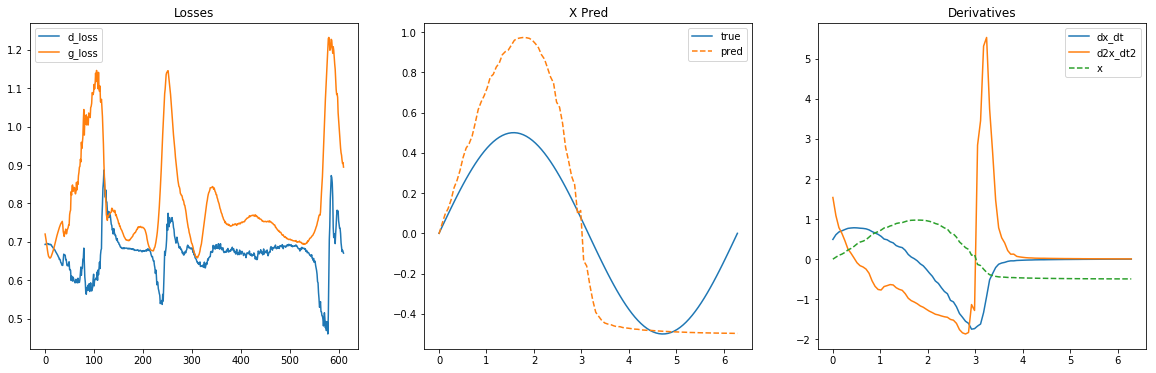

In [ ]:
%%time
torch.manual_seed(42)
G,D1,D2,G_loss,D_loss = train_GAN_SHO(5000, 
                              g_hidden_units=30, 
                              g_hidden_layers=3,
                              d_hidden_units=20, 
                              d_hidden_layers=2,
                              d_lr=0.001,
                              g_lr=0.001,
                              t_low=0,
                              t_high=2*np.pi,
                              logging=False,
                              G_iters=4,
                              D_iters=1,
                              n=100,
                              x0=0.,
                              gp_hyper=0.1,
                              dx_dt0=.5,
                              realtime_plot=True,
                              activation=nn.Tanh(),
                              wgan=False,
                              soft_labels=True,
                              real_data=False,
                              gradient_penalty=True,
                              systemOfODE=True)